In [1]:
# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

import cv2
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from PIL import Image

# Plots
import matplotlib.pyplot as plt

# Utils
import numpy as np
from collections import OrderedDict
from tqdm import tqdm, trange
import os

D:\Lucru\github-folder\itec-2022\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The ImageFolder dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.ImageFolder(r'D:/Lucru/github-folder/itec-2022/dataset/dataset-shape', transform=transform)

In [3]:
dataset.classes

['ellipse', 'rectangle', 'triangle']

In [4]:
train_len = int(.75 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

In [5]:
resnet18 = torchvision.models.resnet18(pretrained = True)

In [7]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,128)),
    ('dropout', nn.Dropout(p = .5)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(128,3)),
    ('output', nn.LogSoftmax(dim=1))
]))
resnet18.fc = fc

In [8]:
# Unfreeze last layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

In [10]:
learning_rate = .0001
optimizer = torch.optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
epochs = 10
accs = []
losses = []
val_losses = []
val_accs = []
for epoch in (t:= trange(epochs)):
    resnet18.train() # change resnet here
    # Get batches
    loss = 0.
    acc = 0.
    num_batches = 0
    for X_batch, y_batch in trainloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        y_pred = resnet18(X_batch)
        
        loss_batch = loss_function(y_pred, y_batch)    
        loss += loss_batch.item()
        acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        
        optimizer.zero_grad() # don't forget this
        loss_batch.backward()
        optimizer.step()
    
    acc /= num_batches
    loss /= num_batches
    losses.append(loss)
    accs.append(acc)

    # Validation set
    resnet18.eval()
    num_batches = 0
    val_acc = 0.
    val_loss = 0.
    for X_batch, y_batch in testloader:
        num_batches+=1
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        y_pred = resnet18(X_batch)
        val_acc += accuracy_score(torch.argmax(y_pred.cpu(), axis = 1), y_batch.cpu())
        loss_batch = loss_function(y_pred, y_batch)    
        val_loss += loss_batch.item()
        
    val_acc /= num_batches
    val_loss /= num_batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    t.set_description(f"(Loss, Acc) -- Train : {round(loss, 2), round(acc, 2)}, Test : {round(val_loss, 2), round(val_acc, 2)}")

(Loss, Acc) -- Train : (0.06, 1.0), Test : (0.02, 1.0): 100%|██████████████████████████| 10/10 [01:00<00:00,  6.07s/it]


In [12]:
del X_batch, y_batch
torch.cuda.empty_cache()

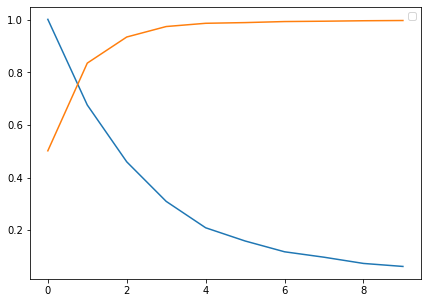

In [14]:
plt.figure(figsize = (7, 5))
plt.legend(['Loss','Accuracy'])
plt.plot(losses)
plt.plot(accs)

In [16]:
torch.save(resnet18.state_dict(), r"D:/Lucru/github-folder/itec-2022/resnet18_shape.pth")